In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nyse/securities.csv
/kaggle/input/nyse/fundamentals.csv
/kaggle/input/nyse/prices-split-adjusted.csv
/kaggle/input/nyse/prices.csv
/kaggle/input/googledta/testset.csv
/kaggle/input/googledta/trainset.csv


In [2]:
import numpy as np
import pandas as pd
from keras.layers import LSTM, Dense, Dropout, Embedding
from keras.models import Sequential
import tqdm
import math
from sklearn.metrics import mean_squared_error

In [3]:
dataset =  pd.read_csv('../input/nyse/prices.csv')
dataset

,date,symbol,open,close,low,high,volume
0,2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
1,2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2,2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
3,2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
4,2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0
...,...,...,...,...,...,...,...
851259,2016-12-30,ZBH,103.309998,103.199997,102.849998,103.930000,973800.0
851260,2016-12-30,ZION,43.070000,43.040001,42.689999,43.310001,1938100.0
851261,2016-12-30,ZTS,53.639999,53.529999,53.270000,53.740002,1701200.0
851262,2016-12-30 00:00:00,AIV,44.730000,45.450001,44.410000,45.590000,1380900.0


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 851264 entries, 0 to 851263
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    851264 non-null  object 
 1   symbol  851264 non-null  object 
 2   open    851264 non-null  float64
 3   close   851264 non-null  float64
 4   low     851264 non-null  float64
 5   high    851264 non-null  float64
 6   volume  851264 non-null  float64
dtypes: float64(5), object(2)
memory usage: 45.5+ MB


In [5]:
dataset.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,70.836986,70.857109,70.118414,71.543476,5.415113e+06
std,83.695876,83.689686,82.877294,84.465504,1.249468e+07
min,0.850000,0.860000,0.830000,0.880000,0.000000e+00
25%,33.840000,33.849998,33.480000,34.189999,1.221500e+06
50%,52.770000,52.799999,52.230000,53.310001,2.476250e+06
75%,79.879997,79.889999,79.110001,80.610001,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [6]:
dataset.symbol.unique()

array(['WLTW', 'A', 'AAL', 'AAP', 'AAPL', 'ABC', 'ABT', 'ACN', 'ADBE',
       'ADI', 'ADM', 'ADP', 'ADS', 'ADSK', 'AEE', 'AEP', 'AES', 'AET',
       'AFL', 'AGN', 'AIG', 'AIZ', 'AJG', 'AKAM', 'ALB', 'ALK', 'ALL',
       'ALXN', 'AMAT', 'AME', 'AMG', 'AMGN', 'AMP', 'AMT', 'AMZN', 'AN',
       'ANTM', 'AON', 'APA', 'APC', 'APD', 'APH', 'ARNC', 'ATVI', 'AVB',
       'AVGO', 'AVY', 'AWK', 'AXP', 'AYI', 'AZO', 'BA', 'BAC', 'BAX',
       'BBBY', 'BBT', 'BBY', 'BCR', 'BDX', 'BEN', 'BHI', 'BIIB', 'BK',
       'BLK', 'BLL', 'BMY', 'BSX', 'BWA', 'BXP', 'C', 'CA', 'CAG', 'CAH',
       'CAT', 'CB', 'CBG', 'CBS', 'CCI', 'CCL', 'CELG', 'CERN', 'CF',
       'CHD', 'CHK', 'CHRW', 'CI', 'CINF', 'CL', 'CLX', 'CMA', 'CMCSA',
       'CME', 'CMG', 'CMI', 'CMS', 'CNC', 'CNP', 'COF', 'COG', 'COH',
       'COL', 'COO', 'COP', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTL', 'CTSH', 'CTXS', 'CVS', 'CVX', 'CXO', 'D', 'DAL', 'DD', 'DE',
       'DFS', 'DG', 'DGX', 'DHI', 'DHR', 'DIS', 'DISCA', 'DISCK', 

In [7]:
dataset = dataset[dataset.symbol == 'IBM']
# dataset.plot()


In [8]:
dataset=dataset.reset_index()['close']

In [9]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
dataset=scaler.fit_transform(np.array(dataset).reshape(-1,1))

In [10]:
training_size=int(len(dataset)*0.65)
test_size=len(dataset)-training_size
train_data,test_data=dataset[0:training_size,:],dataset[training_size:len(dataset),:1]

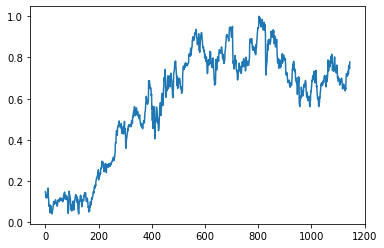

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.plot(train_data)

In [12]:

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)


In [13]:
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [14]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [15]:

model=Sequential()
model.add(LSTM(60,return_sequences=True,input_shape=(100,1)))
model.add(Dropout(.2))
model.add(LSTM(60,return_sequences=True))
model.add(Dropout(.2))
model.add(LSTM(60))
model.add(Dropout(.2))
model.add(Dense(30))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam',  metrics= ['accuracy'])


In [16]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 2s 89ms/step - loss: 0.1047 - accuracy: 9.5785e-04 - val_loss: 0.0054 - val_accuracy: 0.0019
Epoch 2/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0163 - accuracy: 9.5785e-04 - val_loss: 0.0058 - val_accuracy: 0.0019
Epoch 3/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0115 - accuracy: 9.5785e-04 - val_loss: 0.0044 - val_accuracy: 0.0019
Epoch 4/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0081 - accuracy: 9.5785e-04 - val_loss: 0.0025 - val_accuracy: 0.0019
Epoch 5/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0075 - accuracy: 9.5785e-04 - val_loss: 0.0026 - val_accuracy: 0.0019
Epoch 6/100
17/17 [==============================] - 0s 24ms/step - loss: 0.0064 - accuracy: 9.5785e-04 - val_loss: 0.0030 - val_accuracy: 0.0019
Epoch 7/100
17/17 [==============================] - 0s 23ms/step - loss: 0.0061 - accuracy: 9.5785e-04 - val_loss: 0.0028 -

Epoch 57/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0022 - accuracy: 9.5785e-04 - val_loss: 0.0025 - val_accuracy: 0.0019
Epoch 58/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0024 - accuracy: 9.5785e-04 - val_loss: 0.0017 - val_accuracy: 0.0019
Epoch 59/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0024 - accuracy: 9.5785e-04 - val_loss: 0.0015 - val_accuracy: 0.0019
Epoch 60/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0023 - accuracy: 9.5785e-04 - val_loss: 0.0014 - val_accuracy: 0.0019
Epoch 61/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0025 - accuracy: 9.5785e-04 - val_loss: 0.0019 - val_accuracy: 0.0019
Epoch 62/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0023 - accuracy: 9.5785e-04 - val_loss: 0.0014 - val_accuracy: 0.0019
Epoch 63/100
17/17 [==============================] - 0s 20ms/step - loss: 0.0023 - accuracy: 9.5785e-04 - val_loss: 0

In [17]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [18]:
train_predict_denorm=scaler.inverse_transform(train_predict)
test_predict_denorm=scaler.inverse_transform(test_predict)

In [19]:

mse = mean_squared_error(y_train,train_predict_denorm)
math.sqrt(mse)

181.2632954313161

In [20]:
mse = mean_squared_error(ytest,test_predict_denorm)
math.sqrt(mse)

155.21218399025085

In [21]:
look_back=100

In [22]:
original_data = scaler.inverse_transform(dataset)

In [23]:

trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict_denorm)+look_back, :] = train_predict_denorm


In [24]:
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict_denorm)+(look_back*2)+1:len(dataset)-1, :] = test_predict_denorm

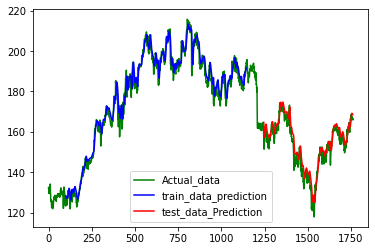

In [25]:
import matplotlib.pyplot as plt2
plt2.plot(original_data,color='green', label='Actual_data')
plt2.plot(trainPredictPlot,color='blue', label='train_data_prediction')
plt2.plot(testPredictPlot,color='red', label='test_data_Prediction')

plt2.legend(loc='best')
plt2.show()

In [26]:
len(test_data)
test_data

array([[0.77366006],
       [0.79009702],
       [0.7815211 ],
       [0.79560997],
       [0.78325682],
       [0.77743745],
       [0.75364978],
       [0.72792233],
       [0.73292493],
       [0.70699341],
       [0.69545686],
       [0.67840737],
       [0.70219503],
       [0.7107708 ],
       [0.70944354],
       [0.71567121],
       [0.71495665],
       [0.709852  ],
       [0.73006635],
       [0.73731501],
       [0.73762128],
       [0.74915767],
       [0.74078614],
       [0.74844311],
       [0.76712612],
       [0.75957119],
       [0.75701887],
       [0.76008169],
       [0.75252676],
       [0.75650837],
       [0.74354253],
       [0.74885141],
       [0.73802958],
       [0.73649825],
       [0.75232252],
       [0.75416028],
       [0.74966817],
       [0.75507908],
       [0.76681986],
       [0.76518633],
       [0.77488513],
       [0.77743745],
       [0.76835119],
       [0.75313929],
       [0.76018373],
       [0.72649304],
       [0.73721283],
       [0.732

In [27]:
x_input=(test_data[517:].reshape(1,-1))

In [28]:
pred_over_test =x_input[0].tolist()


In [29]:
from numpy import array

future=[]
time_steps=100
i=0

# Here we are just reshaping and predicting the test data for next days. 
while(i<40):
    
    if(len(pred_over_test)>100):
        
        # We just convert the test data to array and pass the next data of 
        # the time step length excluding the last value i.e considering only the values we 
        # get from shifting. Reshaping those values to make them feedable to the model and 
        # finally predict the results. Add the output to the list.. and till 30 iteration the loop will go on.
        # we are adding one to the 'i' just to make arrival of the next day.
        
        x_input=np.array(pred_over_test[1:])

        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, time_steps, 1))
     
        yhat = model.predict(x_input, verbose=0)
        pred_over_test.extend(yhat[0].tolist())
        pred_over_test=pred_over_test[1:]
  
        future.extend(yhat.tolist())
        i=i+1
    else:
#         This block works only the first time, and the same steps are coded here.
        x_input = x_input.reshape((1, time_steps,1))
        yhat = model.predict(x_input, verbose=0)
        pred_over_test.extend(yhat[0].tolist())
        future.extend(yhat.tolist())
        i=i+1
    

print(future)

[[0.514125406742096], [0.514413058757782], [0.5167083144187927], [0.520334780216217], [0.5246933102607727], [0.5294007062911987], [0.5342497825622559], [0.5391383171081543], [0.5440155267715454], [0.5488526821136475], [0.5536295175552368], [0.5583305358886719], [0.5629430413246155], [0.5674582719802856], [0.5718712210655212], [0.5761798620223999], [0.5803855657577515], [0.5844917893409729], [0.5885040760040283], [0.5924293994903564], [0.5962753891944885], [0.6000500917434692], [0.6037616729736328], [0.6074182391166687], [0.6110272407531738], [0.6145958304405212], [0.6181300282478333], [0.621635377407074], [0.6251164674758911], [0.6285773515701294], [0.6320207715034485], [0.6354491114616394], [0.6388640999794006], [0.6422665119171143], [0.645656943321228], [0.6490354537963867], [0.6524015665054321], [0.6557546854019165], [0.6590937972068787], [0.6624178886413574]]


1762

In [ ]:
# Welcome to the future
past_data=np.arange(1,101)
fut_data=np.arange(101,141)
plt.plot(past_data,scaler.inverse_transform(dataset[1662:]))
plt.plot(fut_data,scaler.inverse_transform(future))